In [1]:
import tensorflow  as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras

for module in tf, np, pd:
    print(module.__name__, module.__version__)

tensorflow 2.1.0
numpy 1.18.2
pandas 1.0.3


In [3]:
!pip install tensorflow_hub


     |████████████████████████████████| 89 kB 11.6 MB/s eta 0:00:01


In [4]:
import tensorflow_hub as hub

In [5]:
# ImageNet分类器
## 下载分类器
### 使用hub.module加载mobilenet，并tf.keras.layers.Lambda包裹起来作为keras层。hub.tensorflow.google.cn中任何与TensorFlow 2兼容的图像分类器URL都可以在这里使用。

classifier_url ="https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}


In [6]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [7]:
IMAGE_SHAPE = (224, 224)
IMAGE_SHAPE+(3,)

(224, 224, 3)

65536/61306 [================================] - 0s 0us/step


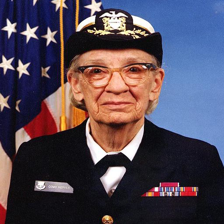

In [8]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [9]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [10]:
grace_hopper[np.newaxis, ...].shape#np.newaxis的作用就是在这一位置增加一个一维.

(1, 224, 224, 3)

In [11]:
np.array([grace_hopper]).shape#在第一维增加等同与这样。

(1, 224, 224, 3)

In [12]:
grace_hopper.reshape([1,224,224,3]).shape# 或这样

(1, 224, 224, 3)

In [13]:
# 添加批次尺寸，然后将图像传递给模型。
result = classifier.predict(grace_hopper[np.newaxis, ...])#np.newaxis的作用就是在这一位置增加一个一维.
result.shape


(1, 1001)

In [16]:
# 结果是logit的1001元素向量，对图像的每个类别的概率进行评级。
# 因此，可以使用argmax找到顶级类ID：
predicted_class = np.argmax(result[0], axis=-1)# 选取概率值最大者的索引
predicted_class

653

In [17]:
# 解码预测
# 根据预测的类ID，获取ImageNet标签并解码预测
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [18]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [20]:
imagenet_labels[predicted_class]

'military uniform'

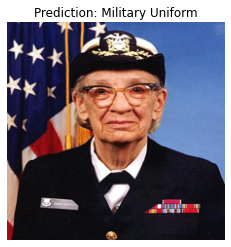

In [19]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title("Prediction: " + predicted_class_name.title())
plt.show()

# 简单的转移学习
## 使用TF Hub可以很容易地重新训练模型的顶层，以识别数据集中的类。

In [21]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 4s 0us/step


In [22]:
str(data_root)


'/home/zo1zu22/.keras/datasets/flower_photos'

In [23]:
IMAGE_SHAPE = (224, 224)
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [24]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [25]:
# 在一批图像上运行分类器
# 现在在图像批处理上运行分类器。
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [26]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
# np.argmax(a)#取出a中元素最大值所对应的索引
predicted_class_names

array(['cardoon', 'daisy', 'sea urchin', 'window screen', 'daisy',
       'daisy', 'daisy', 'picket fence', 'daisy', 'sea urchin', 'torch',
       'bee', 'buckeye', 'feather boa', 'daisy', 'daisy', 'sea urchin',
       'guillotine', 'picket fence', 'daisy', 'daisy', 'daisy',
       'tarantula', 'picket fence', 'agaric', 'orange',
       'Bedlington terrier', 'hip', 'shower curtain', 'daisy',
       'tarantula', 'hip'], dtype='<U30')

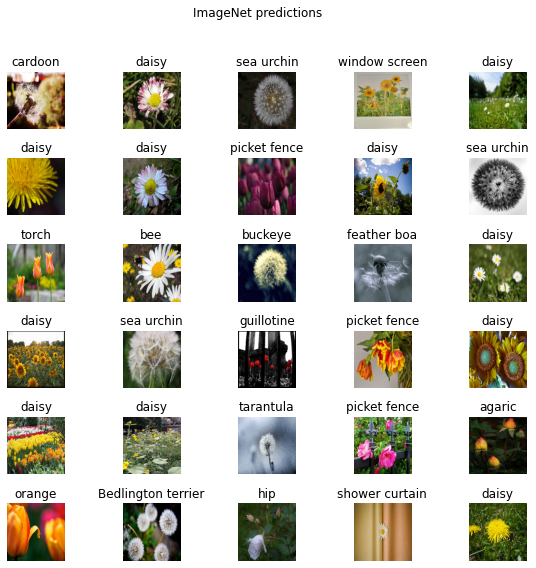

In [27]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
# 结果远非完美，但考虑到这些不是模型训练的类别（“雏菊”除外），这是合理的。



# 下载无头模型
TensorFlow Hub还可以分发没有顶层分类层的模型。这些可以用来轻松进行转移学习。

hub.tensorflow.google.cn中任何与Tensorflow 2兼容的图像特征矢量URL都可以在这里使用。

In [ ]:
feature_extractor_url = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

# 创建特征提取器。
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


In [ ]:
# 它为每个图像返回1280个长度的向量：

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

In [ ]:
# 在特征提取器层中冻结变量，以便训练仅修改新的分类器层。

feature_extractor_layer.trainable = False

model = keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(image_data.num_classes)#image_data.num_classes：label的数量
])
model.summary()

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
# 现在使用该.fit方法训练模型。

# 为了使该示例短时训练仅2个纪元。要可视化培训进度，请使用自定义回调来分别记录每个批次的损失和准确性，而不是历时平均值。

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

 # tips: generator   image_data可直接调用属性
* image_data.num_classes

* image_data.samples

* image_data.batch_size

* image_data.class_indices

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)#ceil向上取整，floor向下取整

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])
# 现在fit已经支持generator，不推荐使用fit_generator

In [ ]:
# 现在，即使只是几次训练迭代，我们已经可以看到模型在任务上取得了进展。
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)


In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

# 检查预测
要重做之前的图，请首先获取类名称的有序列表：

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

In [ ]:
# 通过模型运行图像批处理并将索引转换为类名称。


predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"#注意这种用法
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

#导出模型
### 现在您已经训练了模型，将其导出为保存的模型：

In [ ]:
import time
t = time.time()

export_path = "data/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

### 现在确认我们可以重新加载它，并且仍然得到相同的结果：



In [ ]:
reloaded_model = tf.keras.models.load_model(export_path)


In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()